**Extract Frames**

In [ ]:
import cv2
import os

def extract_frames(video_path, output_folder, frame_rate=1):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    vidcap = cv2.VideoCapture(video_path)
    success, image = vidcap.read()
    count = 0

    while success:
        if count % frame_rate == 0:
            cv2.imwrite(os.path.join(output_folder, f"frame{count}.jpg"), image)
        success, image = vidcap.read()
        count += 1

video_path = 'nakawa_output.avi'
output_folder = 'extracted_frames'
extract_frames(video_path, output_folder, frame_rate=30)  # Adjust frame_rate as needed

**Annotate Frames**

In [ ]:
!pip install label-studio


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Load the dataset**

In [2]:
import json

with open('/content/drive/MyDrive/annotations/result.json', 'r') as f:
    data = json.load(f)
images = data['images']



**Extract features and prepare dataset**

In [3]:
import json
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import os
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score



def extract_features(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to read image at {image_path}")
        return None
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    elif len(image.shape) == 2:
        gray = image
    else:
        print(f"Unexpected image shape: {image.shape}")
        return None

    hog_features = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), block_norm='L2-Hys',
                       visualize=False)
    return hog_features

# Load the annotations
with open('/content/drive/MyDrive/annotations/result.json', 'r') as f:
    annotations = json.load(f)

images = annotations['images']
annotations_list = annotations['annotations']
categories = {cat['id']: cat['name'] for cat in annotations['categories']}

# Define the base path where the images are located
base_path = '/content/drive/MyDrive/annotations/'

# Create a mapping from image_id to category_id
image_id_to_category = {ann['image_id']: ann['category_id'] for ann in annotations_list}

# Extract features and labels
X = []
y = []
for image_info in images:
    image_id = image_info['id']
    if image_id in image_id_to_category:
        category_id = image_id_to_category[image_id]
        category_name = categories[category_id]

        image_path = os.path.join(base_path, image_info['file_name'].replace('\\', '/'))
        # print(f"Trying to read image at {image_path}")
        features = extract_features(image_path)
        if features is not None:
            X.append(features)
            y.append(category_name)
    else:
        print(f"No category found for image_id {image_id}")

# Ensure X and y are numpy arrays
X = np.array(X)
y = np.array(y)

# Verify the classes in the dataset
unique_classes, class_counts = np.unique(y, return_counts=True)
print(f"Classes in the dataset: {unique_classes}")
print(f"Class counts: {class_counts}")

# Check if the dataset is empty
if len(X) == 0:
    print("No images were processed successfully.")
else:
    # Split the dataset (train-test split) without stratification
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Now you can proceed with training your models using X_train and y_train, and evaluating them on X_test and y_test

    print(f"Training set size: {len(X_train)}")
    print(f"Testing set size: {len(X_test)}")

    # Example of training a simple model (replace with your actual model training code)
    model = SVC(probability=True)
    model.fit(X_train, y_train)

    # Example of evaluating the model (replace with your actual evaluation code)
    from sklearn.metrics import accuracy_score
    y_pred = model.predict(X_test)
    print(f"Model accuracy: {accuracy_score(y_test, y_pred)}")




Classes in the dataset: ['bus' 'car' 'jeep' 'motorcycle' 'truck']
Class counts: [4 4 2 7 4]
Training set size: 16
Testing set size: 5
Model accuracy: 0.2


**Train and Evaluate different models**

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder


# Convert labels to numeric format
label_encoder = LabelEncoder()
y_train_numeric = label_encoder.fit_transform(y_train)
y_test_numeric = label_encoder.transform(y_test)

# Train Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train_numeric)
lr_pred_lr = lr_model.predict(X_test)
# lr_auc = roc_auc_score(y_test_numeric, lr_pred_lr, multi_class='ovr')
lr_conf_matrix = confusion_matrix(y_test_numeric, lr_pred_lr)
lr_classification_report = classification_report(y_test_numeric, lr_pred_lr, zero_division=0)

# Train Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train_numeric)
rf_pred_rf = rf_model.predict(X_test)
# rf_auc = roc_auc_score(y_test_numeric, rf_pred_rf, multi_class='ovr')
rf_conf_matrix = confusion_matrix(y_test_numeric, rf_pred_rf)
rf_classification_report = classification_report(y_test_numeric, rf_pred_rf, zero_division=0)

# Train SVM model
svm_model = SVC(probability=True)
svm_model.fit(X_train, y_train_numeric)
svm_pred_svm = svm_model.predict(X_test)
# svm_auc = roc_auc_score(y_test_numeric, svm_pred_svm, multi_class='ovr')
svm_conf_matrix = confusion_matrix(y_test_numeric, svm_pred_svm)
svm_classification_report = classification_report(y_test_numeric, svm_pred_svm, zero_division=0)

# Print results
print("Logistic Regression:")
# print("ROC AUC:", lr_auc)
print("Confusion Matrix:\n", lr_conf_matrix)
print("Classification Report:\n", lr_classification_report)

print("\nRandom Forest:")
# print("ROC AUC:", rf_auc)
print("Confusion Matrix:\n", rf_conf_matrix)
print("Classification Report:\n", rf_classification_report)

print("\nSVM:")
# print("ROC AUC:", svm_auc)
print("Confusion Matrix:\n", svm_conf_matrix)
print("Classification Report:\n", svm_classification_report)


Logistic Regression:
Confusion Matrix:
 [[0 0 3 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 0 0]]
Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         1
           3       0.25      1.00      0.40         1
           4       0.00      0.00      0.00         0

    accuracy                           0.20         5
   macro avg       0.06      0.25      0.10         5
weighted avg       0.05      0.20      0.08         5


Random Forest:
Confusion Matrix:
 [[0 0 0 0 0]
 [0 0 0 3 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [0 0 0 0 0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00       3.0
           2       0.00      0.00      0.00       1.0
           3       0.00      0.00      0.00       1.0
           4       0.00      0.00      0.00       0.0

    a

**Oversampling to improve accuracy**

In [5]:
import json
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score
import os

def extract_features(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to read image at {image_path}")
        return None
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    elif len(image.shape) == 2:
        gray = image
    else:
        print(f"Unexpected image shape: {image.shape}")
        return None

    hog_features = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), block_norm='L2-Hys',
                       visualize=False)
    return hog_features

# Load the annotations
with open('/content/drive/MyDrive/annotations/result.json', 'r') as f:
    annotations = json.load(f)

images = annotations['images']
annotations_list = annotations['annotations']
categories = {cat['id']: cat['name'] for cat in annotations['categories']}

# Define the base path where the images are located
base_path = '/content/drive/MyDrive/annotations/'

# Create a mapping from image_id to category_id
image_id_to_category = {ann['image_id']: ann['category_id'] for ann in annotations_list}

# Extract features and labels
X = []
y = []
for image_info in images:
    image_id = image_info['id']
    if image_id in image_id_to_category:
        category_id = image_id_to_category[image_id]
        category_name = categories[category_id]

        image_path = os.path.join(base_path, image_info['file_name'].replace('\\', '/'))
        features = extract_features(image_path)
        if features is not None:
            X.append(features)
            y.append(category_name)
    else:
        print(f"No category found for image_id {image_id}")

# Ensure X and y are numpy arrays
X = np.array(X)
y = np.array(y)

# Apply oversampling
oversampler = RandomOverSampler()
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Verify the classes in the resampled dataset
unique_classes_resampled, class_counts_resampled = np.unique(y_resampled, return_counts=True)
print(f"Classes in the resampled dataset: {unique_classes_resampled}")
print(f"Class counts in the resampled dataset: {class_counts_resampled}")

# Split the resampled dataset (train-test split) without stratification
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Example of training a simple model (replace with your actual model training code)
model = SVC(probability=True)
model.fit(X_train, y_train)

# Example of evaluating the model (replace with your actual evaluation code)
y_pred = model.predict(X_test)
print(f"Model accuracy: {accuracy_score(y_test, y_pred)}")


Classes in the resampled dataset: ['bus' 'car' 'jeep' 'motorcycle' 'truck']
Class counts in the resampled dataset: [7 7 7 7 7]
Model accuracy: 0.7142857142857143


**Hpertuning parameters and Retraining the models**

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler

# Convert labels to numeric format
label_encoder = LabelEncoder()
y_resampled_numeric = label_encoder.fit_transform(y_resampled)

# Split the resampled dataset (train-test split) without stratification
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled, y_resampled_numeric, test_size=0.2, random_state=42)

# Define parameter grids for hyperparameter tuning
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100]
}

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30]
}


param_grid_svm = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf'],    # Kernel type
    'gamma': ['scale', 'auto']      # Kernel coefficient
}

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Hyperparameter tuning for Logistic Regression
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=5, n_jobs=-1)
grid_lr.fit(X_train_resampled, y_train_resampled)
best_lr = grid_lr.best_estimator_
lr_pred_lr = best_lr.predict(X_test_resampled)
lr_conf_matrix = confusion_matrix(y_test_resampled, lr_pred_lr)
lr_classification_report = classification_report(y_test_resampled, lr_pred_lr, zero_division=0)
print("Logistic Regression:")
print("Best parameters:", grid_lr.best_params_)
print("Confusion Matrix:\n", lr_conf_matrix)
print("Classification Report:\n", lr_classification_report)

# Hyperparameter tuning for Random Forest
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, n_jobs=-1)
grid_rf.fit(X_train_resampled, y_train_resampled)
best_rf = grid_rf.best_estimator_
rf_pred_rf = best_rf.predict(X_test_resampled)
rf_conf_matrix = confusion_matrix(y_test_resampled, rf_pred_rf)
rf_classification_report = classification_report(y_test_resampled, rf_pred_rf, zero_division=0)
print("\nRandom Forest:")
print("Best parameters:", grid_rf.best_params_)
print("Confusion Matrix:\n", rf_conf_matrix)
print("Classification Report:\n", rf_classification_report)

# Hyperparameter tuning for SVM
# grid_svm = GridSearchCV(SVC(probability=True), param_grid_svm, cv=5, n_jobs=-1)
grid_svm = GridSearchCV(SVC(probability=True), param_grid_svm, cv=5, scoring='accuracy')

grid_svm.fit(X_train_resampled, y_train_resampled)
best_svm = grid_svm.best_estimator_
svm_pred_svm = best_svm.predict(X_test_resampled)
svm_conf_matrix = confusion_matrix(y_test_resampled, svm_pred_svm)
svm_classification_report = classification_report(y_test_resampled, svm_pred_svm, zero_division=0)
print("\nSVM:")
print("Best parameters:", grid_svm.best_params_)
print("Confusion Matrix:\n", svm_conf_matrix)
print("Classification Report:\n", svm_classification_report)

# Hyperparameter tuning for K-Nearest Neighbors
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, n_jobs=-1)
grid_knn.fit(X_train_resampled, y_train_resampled)
best_knn = grid_knn.best_estimator_
knn_pred_knn = best_knn.predict(X_test_resampled)
knn_conf_matrix = confusion_matrix(y_test_resampled, knn_pred_knn)
knn_classification_report = classification_report(y_test_resampled, knn_pred_knn, zero_division=0)
print("\nK-Nearest Neighbors:")
print("Best parameters:", grid_knn.best_params_)
print("Confusion Matrix:\n", knn_conf_matrix)
print("Classification Report:\n", knn_classification_report)



Logistic Regression:
Best parameters: {'C': 0.01}
Confusion Matrix:
 [[1 0 0 0 0]
 [0 2 0 0 0]
 [0 0 1 0 0]
 [1 0 1 0 0]
 [0 0 0 0 1]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       1.00      1.00      1.00         2
           2       0.50      1.00      0.67         1
           3       0.00      0.00      0.00         2
           4       1.00      1.00      1.00         1

    accuracy                           0.71         7
   macro avg       0.60      0.80      0.67         7
weighted avg       0.57      0.71      0.62         7


Random Forest:
Best parameters: {'max_depth': 20, 'max_features': 'log2', 'n_estimators': 200}
Confusion Matrix:
 [[1 0 0 0 0]
 [0 2 0 0 0]
 [0 0 1 0 0]
 [0 0 1 1 0]
 [0 0 0 0 1]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00     

**Implementing a voting ensemble using the 3 best performing models**

In [7]:
from sklearn.ensemble import VotingClassifier

# Implement a voting ensemble with the three best models
voting_clf = VotingClassifier(
    estimators=[
        ('knn', best_lr),
        ('rf', best_rf),
        ('svm', best_svm)
    ],
    voting='hard'  # Use 'soft' if you want to average the predicted probabilities
)

voting_clf.fit(X_train_resampled, y_train_resampled)
voting_pred = voting_clf.predict(X_test_resampled)
voting_conf_matrix = confusion_matrix(y_test_resampled, voting_pred)
voting_classification_report = classification_report(y_test_resampled, voting_pred, zero_division=0)

print("\nVoting Classifier:")
print("Confusion Matrix:\n", voting_conf_matrix)
print("Classification Report:\n", voting_classification_report)



Voting Classifier:
Confusion Matrix:
 [[1 0 0 0 0]
 [0 2 0 0 0]
 [0 0 1 0 0]
 [0 0 1 1 0]
 [0 0 0 0 1]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         2
           2       0.50      1.00      0.67         1
           3       1.00      0.50      0.67         2
           4       1.00      1.00      1.00         1

    accuracy                           0.86         7
   macro avg       0.90      0.90      0.87         7
weighted avg       0.93      0.86      0.86         7



**Visualizing my Results**

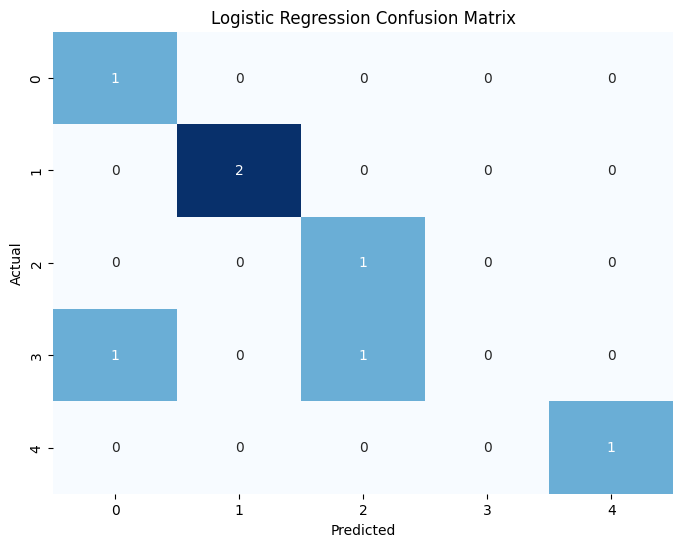

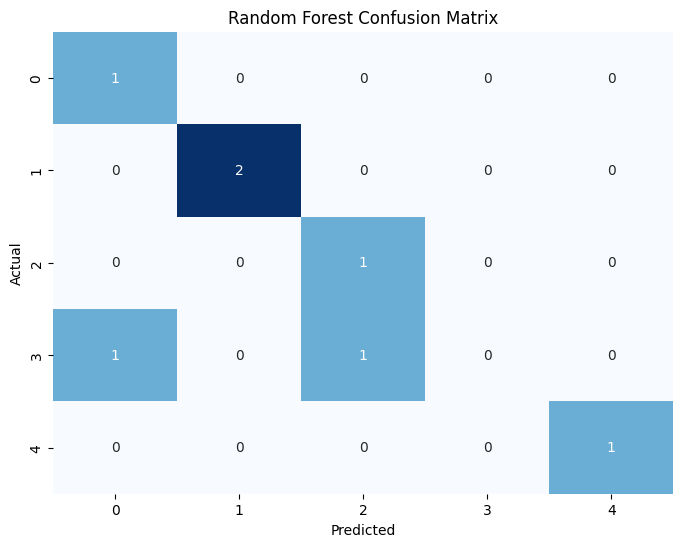

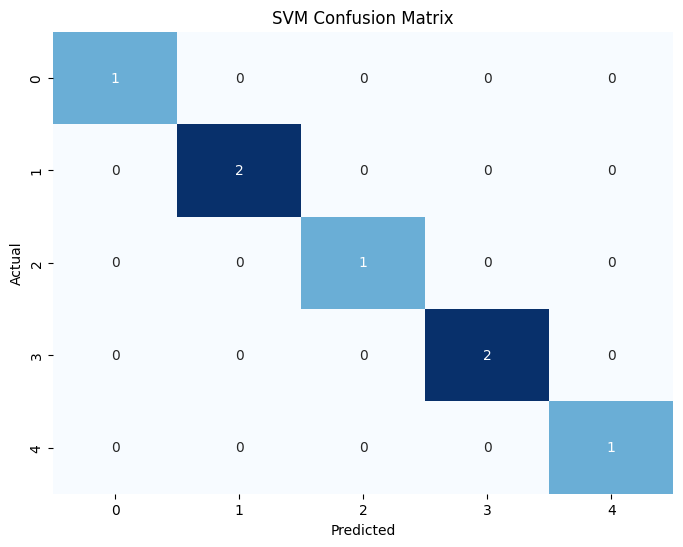

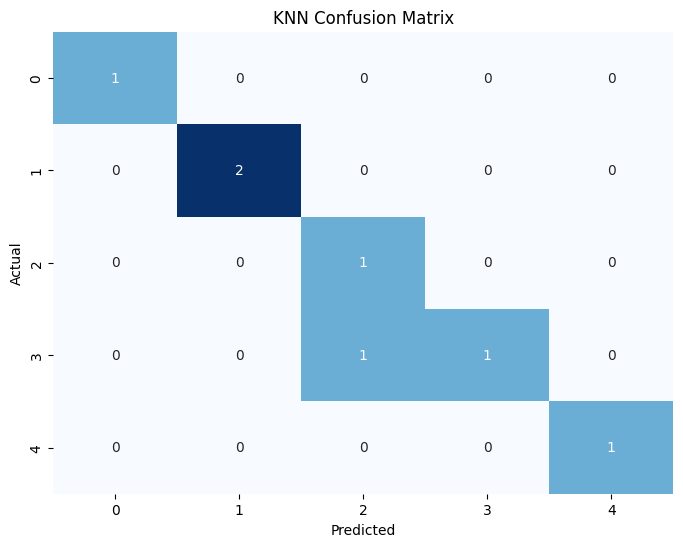

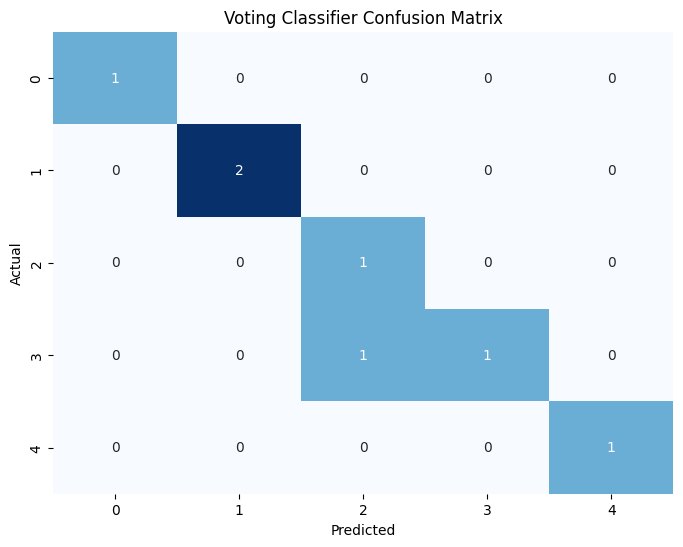

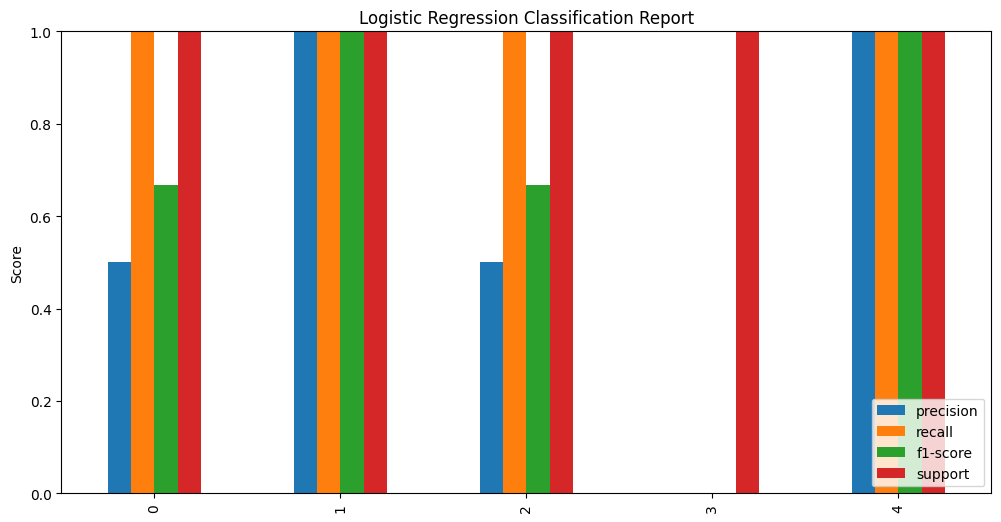

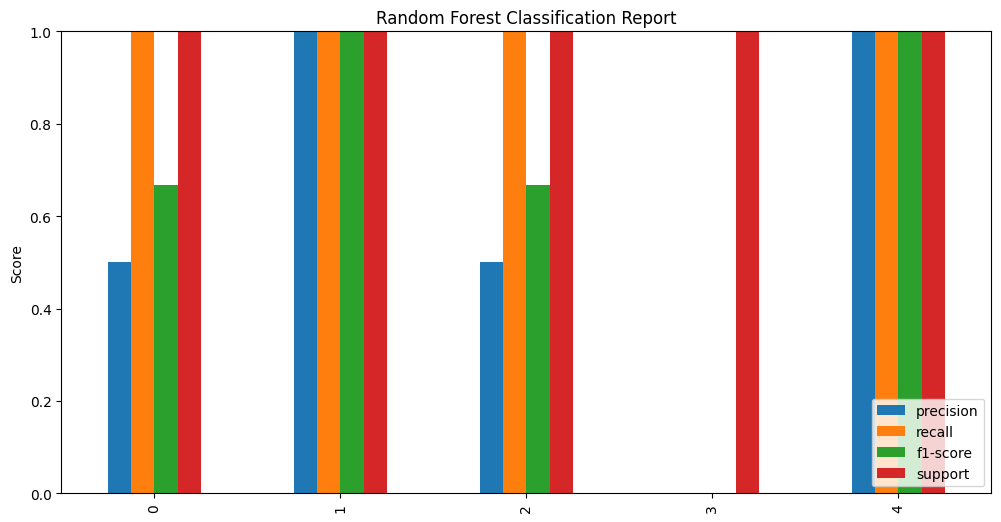

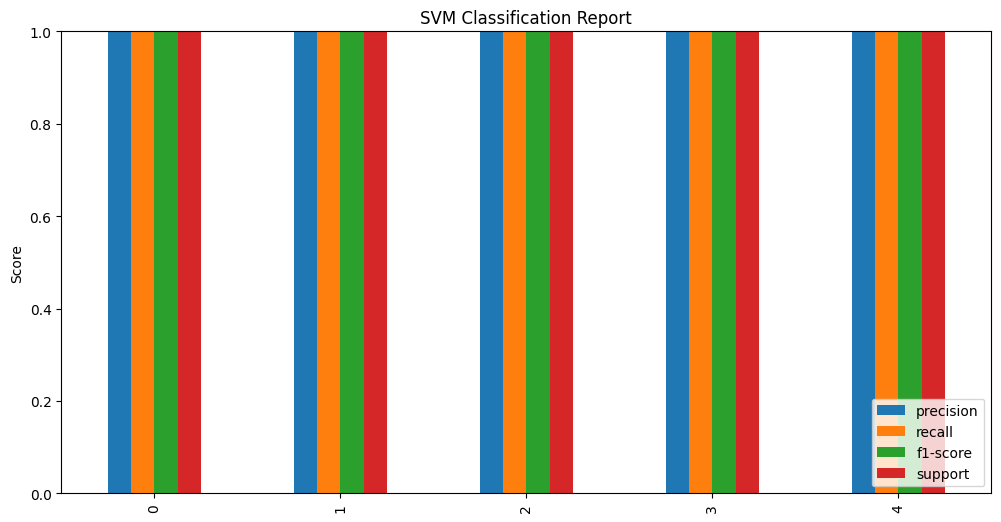

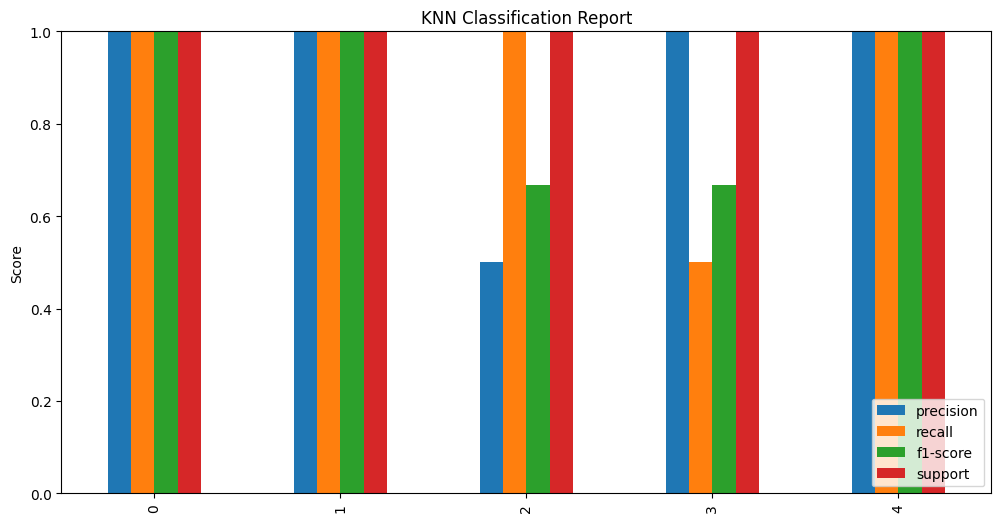

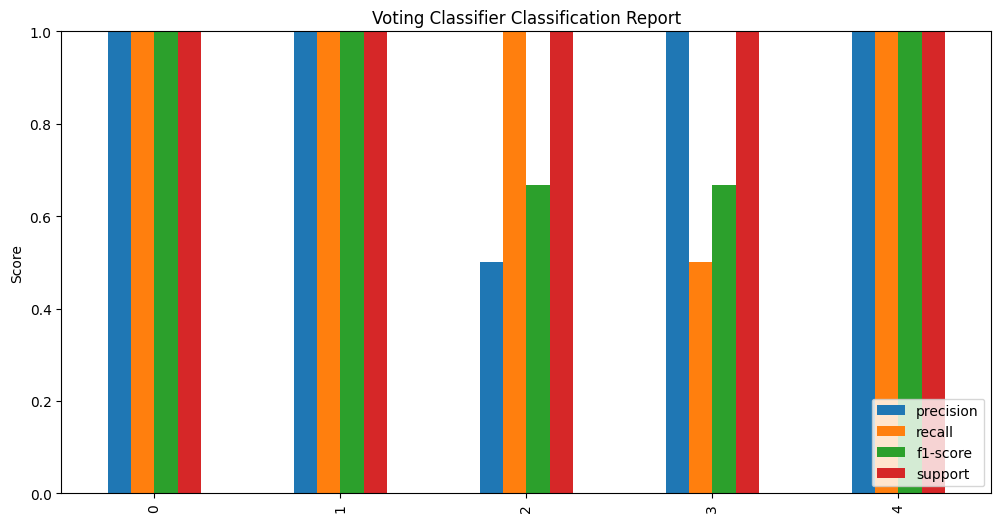

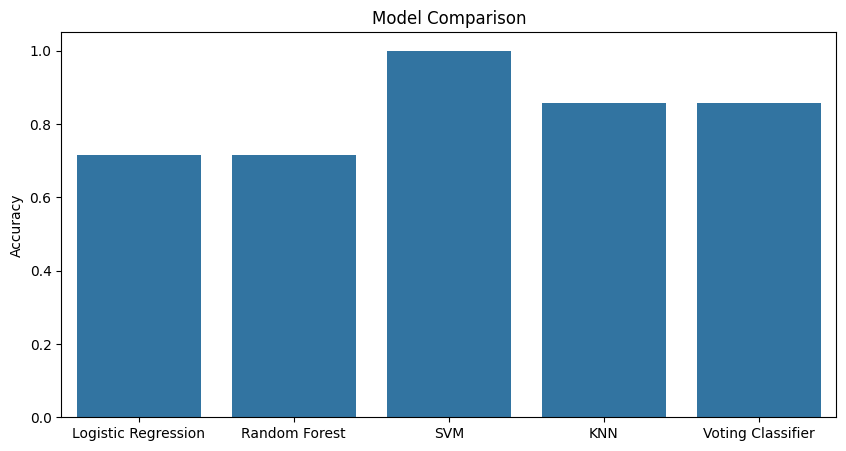

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler

# Convert labels to numeric format
label_encoder = LabelEncoder()
y_resampled_numeric = label_encoder.fit_transform(y_resampled)

# Split the resampled dataset (train-test split) without stratification
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled, y_resampled_numeric, test_size=0.2, random_state=42)

# Define parameter grids for hyperparameter tuning
param_grid_lr = {'C': [0.01, 0.1, 1, 10, 100]}
param_grid_rf = {'n_estimators': [50, 100, 200], 'max_features': ['sqrt', 'log2'], 'max_depth': [None, 10, 20, 30]}
param_grid_svm = {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': ['scale', 'auto', 0.01, 0.1, 1, 10, 100]}
param_grid_knn = {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}

# Hyperparameter tuning for Logistic Regression
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=5, n_jobs=-1)
grid_lr.fit(X_train_resampled, y_train_resampled)
best_lr = grid_lr.best_estimator_
lr_pred_lr = best_lr.predict(X_test_resampled)
lr_conf_matrix = confusion_matrix(y_test_resampled, lr_pred_lr)
lr_classification_report = classification_report(y_test_resampled, lr_pred_lr, zero_division=0, output_dict=True)

# Hyperparameter tuning for Random Forest
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, n_jobs=-1)
grid_rf.fit(X_train_resampled, y_train_resampled)
best_rf = grid_rf.best_estimator_
rf_pred_rf = best_rf.predict(X_test_resampled)
rf_conf_matrix = confusion_matrix(y_test_resampled, rf_pred_rf)
rf_classification_report = classification_report(y_test_resampled, rf_pred_rf, zero_division=0, output_dict=True)

# Hyperparameter tuning for SVM
grid_svm = GridSearchCV(SVC(probability=True), param_grid_svm, cv=5, n_jobs=-1)
grid_svm.fit(X_train_resampled, y_train_resampled)
best_svm = grid_svm.best_estimator_
svm_pred_svm = best_svm.predict(X_test_resampled)
svm_conf_matrix = confusion_matrix(y_test_resampled, svm_pred_svm)
svm_classification_report = classification_report(y_test_resampled, svm_pred_svm, zero_division=0, output_dict=True)

# Hyperparameter tuning for K-Nearest Neighbors
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, n_jobs=-1)
grid_knn.fit(X_train_resampled, y_train_resampled)
best_knn = grid_knn.best_estimator_
knn_pred_knn = best_knn.predict(X_test_resampled)
knn_conf_matrix = confusion_matrix(y_test_resampled, knn_pred_knn)
knn_classification_report = classification_report(y_test_resampled, knn_pred_knn, zero_division=0, output_dict=True)

# Implement a voting ensemble with the four best models
voting_clf = VotingClassifier(
    estimators=[
        ('lr', best_lr),
        ('rf', best_rf),
        ('svm', best_svm),
        ('knn', best_knn)
    ],
    voting='hard'  # Use 'soft' if you want to average the predicted probabilities
)

voting_clf.fit(X_train_resampled, y_train_resampled)
voting_pred = voting_clf.predict(X_test_resampled)
voting_conf_matrix = confusion_matrix(y_test_resampled, voting_pred)
voting_classification_report = classification_report(y_test_resampled, voting_pred, zero_division=0, output_dict=True)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(lr_conf_matrix, "Logistic Regression Confusion Matrix")
plot_confusion_matrix(rf_conf_matrix, "Random Forest Confusion Matrix")
plot_confusion_matrix(svm_conf_matrix, "SVM Confusion Matrix")
plot_confusion_matrix(knn_conf_matrix, "KNN Confusion Matrix")
plot_confusion_matrix(voting_conf_matrix, "Voting Classifier Confusion Matrix")

# Function to plot classification report
def plot_classification_report(cr, title):
    cr_df = pd.DataFrame(cr).transpose()
    cr_df = cr_df.drop(['accuracy', 'macro avg', 'weighted avg'])
    cr_df.plot(kind='bar', figsize=(12, 6))
    plt.title(title)
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.legend(loc='lower right')
    plt.show()

# Plot classification reports as bar graphs
plot_classification_report(lr_classification_report, "Logistic Regression Classification Report")
plot_classification_report(rf_classification_report, "Random Forest Classification Report")
plot_classification_report(svm_classification_report, "SVM Classification Report")
plot_classification_report(knn_classification_report, "KNN Classification Report")
plot_classification_report(voting_classification_report, "Voting Classifier Classification Report")

# Comparison of model performances
model_names = ['Logistic Regression', 'Random Forest', 'SVM', 'KNN', 'Voting Classifier']
accuracies = [
    lr_classification_report['accuracy'],
    rf_classification_report['accuracy'],
    svm_classification_report['accuracy'],
    knn_classification_report['accuracy'],
    voting_classification_report['accuracy']
]

plt.figure(figsize=(10, 5))
sns.barplot(x=model_names, y=accuracies)
plt.title('Model Comparison')
plt.ylabel('Accuracy')
plt.show()


**Mitigating Dimensionality**

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [1151 1178 1187 1214 1288 1295 1315 1322 1324 1330 1331 1351 1357 1358
 2537 2564 2573 2600 2674 2681 2701 2708 2710 2716 2717 2737 2743 2744] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


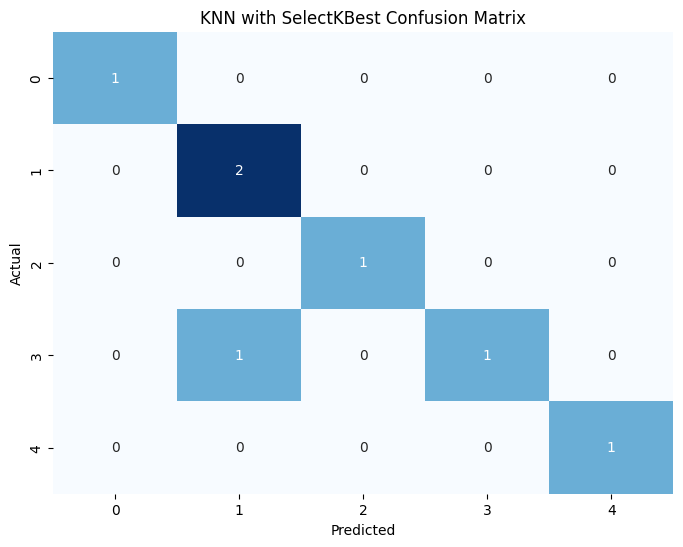

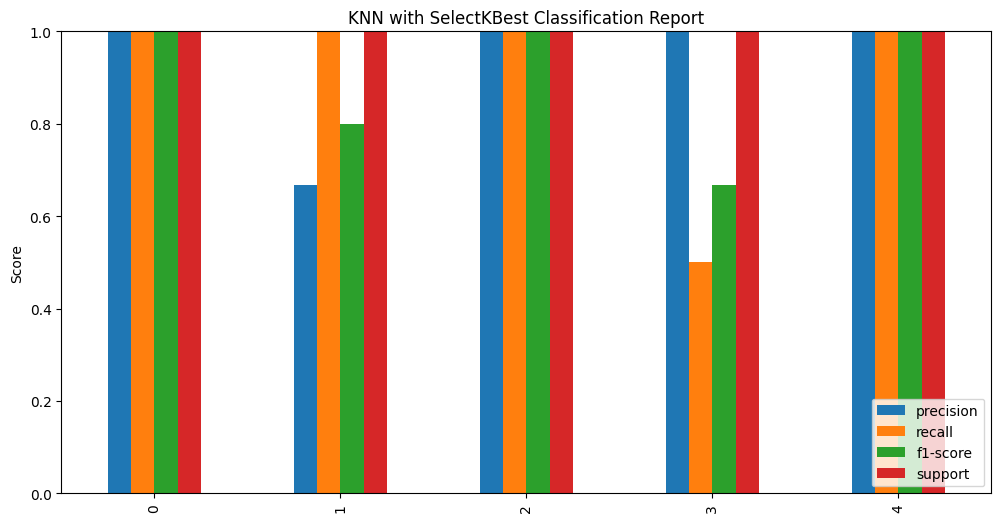

In [11]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Pipeline with PCA
pca_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scale features
    ('pca', PCA(n_components=10)),  # Reduce to 10 principal components
    ('knn', KNeighborsClassifier())
])

# Parameter grid for KNN with PCA
param_grid_pca_knn = {
    'knn__n_neighbors': [3, 5, 7, 9],
    'knn__weights': ['uniform', 'distance']
}

# Hyperparameter tuning for KNN with PCA
grid_pca_knn = GridSearchCV(pca_pipeline, param_grid_pca_knn, cv=5, n_jobs=-1)
grid_pca_knn.fit(X_train_resampled, y_train_resampled)
best_pca_knn = grid_pca_knn.best_estimator_
pca_knn_pred = best_pca_knn.predict(X_test_resampled)
pca_knn_conf_matrix = confusion_matrix(y_test_resampled, pca_knn_pred)
pca_knn_classification_report = classification_report(y_test_resampled, pca_knn_pred, zero_division=0, output_dict=True)

# Pipeline with SelectKBest
select_k_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scale features
    ('select_k', SelectKBest(f_classif, k=10)),  # Select 10 best features
    ('knn', KNeighborsClassifier())
])

# Parameter grid for KNN with SelectKBest
param_grid_select_k_knn = {
    'knn__n_neighbors': [3, 5, 7, 9],
    'knn__weights': ['uniform', 'distance']
}

# Hyperparameter tuning for KNN with SelectKBest
grid_select_k_knn = GridSearchCV(select_k_pipeline, param_grid_select_k_knn, cv=5, n_jobs=-1)
grid_select_k_knn.fit(X_train_resampled, y_train_resampled)
best_select_k_knn = grid_select_k_knn.best_estimator_
select_k_knn_pred = best_select_k_knn.predict(X_test_resampled)
select_k_knn_conf_matrix = confusion_matrix(y_test_resampled, select_k_knn_pred)
select_k_knn_classification_report = classification_report(y_test_resampled, select_k_knn_pred, zero_division=0, output_dict=True)



# Plot results for KNN with SelectKBest
plot_confusion_matrix(select_k_knn_conf_matrix, "KNN with SelectKBest Confusion Matrix")
plot_classification_report(select_k_knn_classification_report, "KNN with SelectKBest Classification Report")


**Ensemble model with improved KNN model**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import RandomOverSampler

# Assuming X_resampled and y_resampled are your resampled datasets
# Convert labels to numeric format
label_encoder = LabelEncoder()
y_resampled_numeric = label_encoder.fit_transform(y_resampled)

# Split the resampled dataset (train-test split) without stratification
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled, y_resampled_numeric, test_size=0.2, random_state=42)

# Define parameter grid for KNN
param_grid_knn = {
    'knn__n_neighbors': [3, 5, 7, 9],
    'knn__weights': ['uniform', 'distance']
}

# Pipeline with SelectKBest and KNN
select_k_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scale features
    ('select_k', SelectKBest(f_classif, k=10)),  # Select 10 best features
    ('knn', KNeighborsClassifier())
])

# Hyperparameter tuning for KNN with SelectKBest
grid_select_k_knn = GridSearchCV(select_k_pipeline, param_grid_knn, cv=5, n_jobs=-1)
grid_select_k_knn.fit(X_train_resampled, y_train_resampled)
best_select_k_knn = grid_select_k_knn.best_estimator_
select_k_knn_pred = best_select_k_knn.predict(X_test_resampled)
select_k_knn_conf_matrix = confusion_matrix(y_test_resampled, select_k_knn_pred)
select_k_knn_classification_report = classification_report(y_test_resampled, select_k_knn_pred, zero_division=0, output_dict=True)

# Define the best Logistic Regression and Random Forest models (assumed to be obtained previously)
# If you haven't obtained these models yet, please refer to the initial code provided to get best_lr and best_rf
# Here we assume best_lr and best_rf are already defined
best_lr = grid_lr.best_estimator_
best_rf = grid_rf.best_estimator_

# Implement a voting ensemble with the three best models
voting_clf = VotingClassifier(
    estimators=[
        ('lr', best_lr),
        ('rf', best_rf),
        ('knn', best_select_k_knn.named_steps['knn'])  # Extract the KNN classifier from the pipeline
    ],
    voting='hard'  # Use 'soft' if you want to average the predicted probabilities
)

voting_clf.fit(X_train_resampled, y_train_resampled)
voting_pred = voting_clf.predict(X_test_resampled)
voting_conf_matrix = confusion_matrix(y_test_resampled, voting_pred)
voting_classification_report = classification_report(y_test_resampled, voting_pred, zero_division=0, output_dict=True)


# Function to plot confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(select_k_knn_conf_matrix, "KNN with SelectKBest Confusion Matrix")
plot_confusion_matrix(voting_conf_matrix, "Voting Classifier Confusion Matrix")

# Function to plot classification report
def plot_classification_report(cr, title):
    cr_df = pd.DataFrame(cr).transpose()
    cr_df = cr_df.drop(['accuracy', 'macro avg', 'weighted avg'])
    cr_df.plot(kind='bar', figsize=(12, 6))
    plt.title(title)
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.legend(loc='lower right')
    plt.show()

# Plot classification reports as bar graphs
plot_classification_report(select_k_knn_classification_report, "KNN with SelectKBest Classification Report")
plot_classification_report(voting_classification_report, "Voting Classifier Classification Report")

# Comparison of model performances
model_names = ['Logistic Regression', 'Random Forest', 'KNN with SelectKBest', 'Voting Classifier']
accuracies = [best_lr.score(X_test_resampled, y_test_resampled),
              best_rf.score(X_test_resampled, y_test_resampled),
              best_select_k_knn.score(X_test_resampled, y_test_resampled),
              voting_clf.score(X_test_resampled, y_test_resampled)]

plt.figure(figsize=(10, 5))
sns.barplot(x=model_names, y=accuracies)
plt.title('Model Comparison')
plt.ylabel('Accuracy')
plt.show()
